# 1 - Setup

Here's where we install, setup and import the fastbook libs

In [1]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
import getpass

# 2 - Get some data
We'll use bing search api to get our dataset.
Each category of images will get it's own subfolder.
This will be important when loading the dataset with the Dataloaders

In [2]:
# Nice way to prompt for API key so we don't have to store it
key = getpass.getpass()

········


In [3]:
tiger_types = 'bengal', 'white', 'teddy'
path = Path('tigers')

In [4]:
path.exists()
# don't forget parenthesis after method calls...

True

In [5]:
if not path.exists():
    path.mkdir()
    for o in tiger_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} tiger')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
# Clean the datasets up by getting rid of dead links
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

# 3 - Load the data
We now need to load our data into a DataLoaders so they can be passed into a learner

In [7]:
# Check the docs
??DataBlock

In [8]:
??Resize

In [9]:
# Getting a Dataloaders from a dataset is a 2-step process. 
# First we initialise the Datablock to tell it what to expect the dataset we're about to give it.
tigers = DataBlock(
    
    # This specifies the types of input (images) and output/predictions (categories) we're working with
    # INput is called the INdependent variable
    # Output is called the Dependent variable
    blocks=(ImageBlock, CategoryBlock),
    
    # This tells the datablock how to read the raw data. 
    # Here we'll using get_image_files() as above
    get_items=get_image_files,
    
    # We'll split the dataset into 2 sets: training and validation
    # The learner will train itself on the training set and validate itself using the validation set.
    # The validation set will take 20% of the master set.
    # The seed is set at 42 so re-running against the same set will produce the same training/validation set for consistency
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    
    # get_y tells it how to label or categorise each item in the dataset.
    # parent_label is a built-in function that returns the name of the parent dir
    # Our tiger dataset is currently divided into subdirs tigers/bengali, tigers/white, tigers/teddy
    # Some datasets follow other conventions like having everything in the one dir but the filename 
    # has a particular format to differentiate categories. You could write a small custom function to parse each name
    # and return the label
    get_y=parent_label,
    
    # We need to resize our images to a uniform size.
    # This is so they can be passed around in a uniformly sized array to the GPU
    item_tfms=Resize(128))

In [10]:
# Now that we have our DataBlock template ready to go, we can give it our raw data
dataloaders = tigers.dataloaders(path)

In [11]:
??dataloaders.valid.show_batch

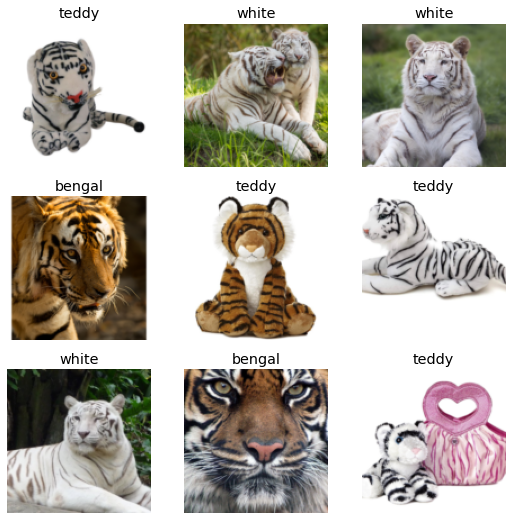

In [12]:
dataloaders.valid.show_batch()

In [13]:
??aug_transforms

In [14]:
# We can augment the data by telling the DataBlock to do some random resizing and cropping on it's training set
# tigers.new is a handy way to update an existing DataBlock rather than starting from scratch
# Just override the params you want updated
tigers = tigers.new(
    # Randomly crop to various points of the image to artificially introduce more variety to the training set.
    # This will make it a bit more robust and (hopefully) able to recognise a wider variety of images
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    # The aug_transforms will create skewed images in the training set for the same reason, more variety
    batch_tfms=aug_transforms())

In [15]:
dataloaders = tigers.dataloaders(path)

# 4 - Training time
Now we've got the data ready to provide to a learner

In [16]:
??cnn_learner

In [17]:
learner = cnn_learner(dataloaders, resnet18, metrics=error_rate)
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.637212,0.493903,0.172414,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.491588,0.483190,0.137931,00:07
1,0.418902,0.521346,0.114943,00:08
2,0.368688,0.542724,0.126437,00:08
3,0.326788,0.517636,0.126437,00:07


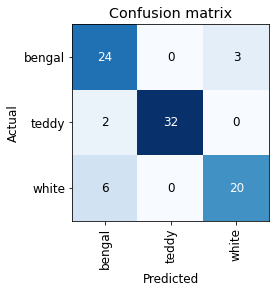

In [18]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

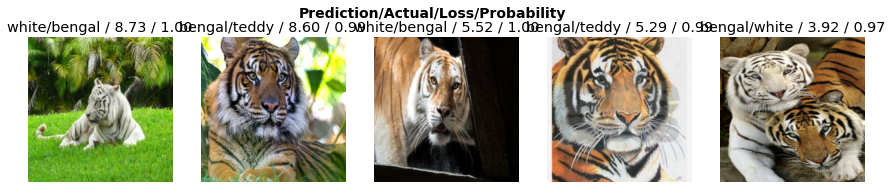

In [19]:
interp.plot_top_losses(5, nrows=1)